# Исследовательский анализ данных в Python и проверка гипотез. Знакомство с данными Яндекс Афиша

- Автор: Бесаева Аза
- Дата: 21.08.2025

### Цели и задачи проекта

Цель проекта проанализировать данные сервиса Яндекс Афиша за период с 1 июня по 31 октября 2024 года и проверить изменения пользовательских предпочтений и популярности событий осенью 2024 года, а также проверить гипотезу о разнице в поведении пользователей с мобильных и стационарных устройств

### Описание данных

Первый датасет **final_tickets_orders_df.csv** включает информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных.

Поля датасета соответствуют таблице `purchases`:

`order_id` — уникальный идентификатор заказа.

`user_id` — уникальный идентификатор пользователя.

`created_dt_msk` — дата создания заказа (московское время).

`created_ts_msk` — дата и время создания заказа (московское время).

`event_id` — идентификатор мероприятия из таблицы events.

`cinema_circuit` — сеть кинотеатров. Если не применимо, то здесь будет значение 'нет'.

`age_limit` — возрастное ограничение мероприятия.

`currency_code` — валюта оплаты, например rub для российских рублей.

`device_type_canonical` — тип устройства, с которого был оформлен заказ, например `mobile` для мобильных устройств, 

`desktop` для стационарных;

`revenue` — выручка от заказа.

`service_name` — название билетного оператора.

`tickets_count` — количество купленных билетов.

`total` — общая сумма заказа.

В данные также был добавлен столбец `days_since_prev` с количеством дней с предыдущей покупки для каждого пользователя. Если покупки не было, то данные содержат пропуск.

Второй датасет **final_tickets_events_df.csv** содержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия.

Датасет содержит такие поля:

`event_id` — уникальный идентификатор мероприятия.

`event_name` — название мероприятия. Аналог поля event_name_code из исходной базы данных.

`event_type_description` — описание типа мероприятия.

`event_type_main` — основной тип мероприятия: театральная постановка, концерт и так далее.

`organizers` — организаторы мероприятия.

`region_name` — название региона.

`city_name` — название города.

`venue_id` — уникальный идентификатор площадки.

`venue_name` — название площадки.

`venue_address` — адрес площадки.

Датасет **final_tickets_tenge_df.csv** с информацией о курсе тенге к российскому рублю за 2024 год. Значения в рублях представлено для 100 тенге.

Датасет содержит такие поля:

`nominal` — номинал (100 тенге);

`data` — дата;

`curs` — курс тенге к рублю;

`cdx` — обозначение валюты (kzt).

## Загрузка данных и знакомство с ними

In [2]:
# Импортируем библиотеки
import pandas as pd

# Загружаем библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

In [3]:
# Выгружаем данные датафреймов
orders_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_orders_df.csv')
tickets_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_events_df.csv')
tenge_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [4]:
# Выводим информацию о датафреймах
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), object(7)
m

По данным видим, что столбцы содержат 290849 строк, 14 столбцов, в столбце `days_since_prev` есть пропуски: их 21940 штук (по условию задания они есть)

Но в столбцах `created_dt_msk`, `created_ts_msk` мы видим даты, а тип данных object, поэтому переведём данные в этих столбцах в datetime64

In [5]:
# Преобразуем данные даты из object в datetime64
orders_df['created_dt_msk'] = orders_df['created_dt_msk'].astype('datetime64[ns]')
orders_df['created_ts_msk'] = orders_df['created_ts_msk'].astype('datetime64[ns]')
orders_df.info() # проверим, всё ли верно

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   order_id               290849 non-null  int64         
 1   user_id                290849 non-null  object        
 2   created_dt_msk         290849 non-null  datetime64[ns]
 3   created_ts_msk         290849 non-null  datetime64[ns]
 4   event_id               290849 non-null  int64         
 5   cinema_circuit         290849 non-null  object        
 6   age_limit              290849 non-null  int64         
 7   currency_code          290849 non-null  object        
 8   device_type_canonical  290849 non-null  object        
 9   revenue                290849 non-null  float64       
 10  service_name           290849 non-null  object        
 11  tickets_count          290849 non-null  int64         
 12  total                  290849 non-null  floa

In [6]:
# Применяем метод isna() к датафрейму bank_df
orders_df.isna().sum()

order_id                     0
user_id                      0
created_dt_msk               0
created_ts_msk               0
event_id                     0
cinema_circuit               0
age_limit                    0
currency_code                0
device_type_canonical        0
revenue                      0
service_name                 0
tickets_count                0
total                        0
days_since_prev          21940
dtype: int64

In [7]:
# Подсчитываем долю строк с пропусками
orders_df.isna().sum() / orders_df.shape[0]

order_id                 0.000000
user_id                  0.000000
created_dt_msk           0.000000
created_ts_msk           0.000000
event_id                 0.000000
cinema_circuit           0.000000
age_limit                0.000000
currency_code            0.000000
device_type_canonical    0.000000
revenue                  0.000000
service_name             0.000000
tickets_count            0.000000
total                    0.000000
days_since_prev          0.075434
dtype: float64

In [8]:
# Просмотрим данные в датафрейме orders_df
orders_df

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290844,368620,fffcd3dde79eb2c,2024-10-27,2024-10-27 18:00:57,33189,нет,6,rub,mobile,965.57,Весь в билетах,4,9655.73,0.0
290845,368562,fffcd3dde79eb2c,2024-10-27,2024-10-27 17:53:53,33189,нет,6,rub,mobile,1448.36,Весь в билетах,6,14483.60,0.0
290846,8473772,fffcd3dde79eb2c,2024-10-30,2024-10-30 13:37:43,205231,нет,16,rub,desktop,178.95,Прачечная,2,4473.74,3.0
290847,5526067,fffeeb3c120cf0b,2024-09-24,2024-09-24 10:07:42,454526,нет,18,rub,desktop,661.53,Билеты без проблем,2,6615.34,NaN


In [9]:
# Выводим информацию о датафреймах
tickets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB


In [10]:
# Просмотрим данные в датафрейме tickets_df
tickets_df

,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"
...,...,...,...,...,...,...,...,...,...,...,...
22422,591313,196f51a8-344a-462a-b806-a8467fd0e5fa,спортивное мероприятие,спорт,№1623,Речиновская область,Дальнесветск,65,3721,"Студия графики ""Оттенок"" Инк","ул. Чапаева, д. 8 стр. 1/3"
22423,591859,b2b83233-f861-496c-b6fb-a4fef347deb1,ёлка,ёлки,№1992,Солнечноземская область,Глинополье,56,3005,"Арт-кафе ""Аксессуар"" Лимитед","бул. Логовой, д. 94 к. 1/5"
22424,591877,6bffa2da-51d1-4cfe-accb-a02e617a8180,событие,другое,№1767,Североключевской округ,Ягодинска,21702,3506,"Клуб современных танцев ""Кофе"" Групп","ш. Тупиковое, д. 49 стр. 73"
22425,592322,9283cb32-2750-43cd-b57e-dde9ccd5552e,событие,другое,№3884,Яблоневская область,Светополье,39,1081,"Искусственная сцена ""Краски"" и партнеры","пер. Р.Люксембург, д. 499 к. 997"


В датафрейме 11 столбцов, 22427 строк, пропусков нет

In [11]:
# Выводим информацию о датафреймах
tenge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


В датафрейме 4 столбца, 357 строк, пропусков нет

In [12]:
# Просмотрим данные в датафрейме tenge_df
tenge_df

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt
...,...,...,...,...
352,2024-12-27,100,19.2705,kzt
353,2024-12-28,100,19.5105,kzt
354,2024-12-29,100,19.4860,kzt
355,2024-12-30,100,19.4860,kzt


## Предобработка данных и подготовка их к исследованию

In [13]:
# Проверим категориальные значения в столбцах
for column in ['cinema_circuit','currency_code', 'device_type_canonical', 'service_name']:
    print(f'Распределение категориальных значений по значениям столбца {column}:')
    print(orders_df[column].describe())
    print()

Распределение категориальных значений по значениям столбца cinema_circuit:
count     290849
unique         6
top          нет
freq      289451
Name: cinema_circuit, dtype: object

Распределение категориальных значений по значениям столбца currency_code:
count     290849
unique         2
top          rub
freq      285780
Name: currency_code, dtype: object

Распределение категориальных значений по значениям столбца device_type_canonical:
count     290849
unique         2
top       mobile
freq      232679
Name: device_type_canonical, dtype: object

Распределение категориальных значений по значениям столбца service_name:
count                 290849
unique                    36
top       Билеты без проблем
freq                   63709
Name: service_name, dtype: object



In [14]:
# Проверяем уникальные значения в столбцах
for column in ['cinema_circuit', 'currency_code', 'device_type_canonical', 'service_name']:
    display(f'Уникальные значения в столбце {column}:')
    display(orders_df[column].sort_values().unique())
    display()

'Уникальные значения в столбце cinema_circuit:'

array(['Другое', 'КиноСити', 'Киномакс', 'Москино', 'ЦентрФильм', 'нет'],
      dtype=object)

'Уникальные значения в столбце currency_code:'

array(['kzt', 'rub'], dtype=object)

'Уникальные значения в столбце device_type_canonical:'

array(['desktop', 'mobile'], dtype=object)

'Уникальные значения в столбце service_name:'

array(['Crazy ticket!', 'Show_ticket', 'Билет по телефону',
       'Билеты без проблем', 'Билеты в интернете', 'Билеты в руки',
       'Быстробилет', 'Быстрый кассир', 'Весь в билетах', 'Восьмёрка',
       'Вперёд!', 'Выступления.ру', 'Городской дом культуры',
       'Дом культуры', 'Дырокол', 'За билетом!', 'Зе Бест!', 'КарандашРУ',
       'Кино билет', 'Край билетов', 'Лимоны', 'Лови билет!',
       'Лучшие билеты', 'Мир касс', 'Мой билет', 'Облачко', 'Прачечная',
       'Радио ticket', 'Реестр', 'Росбилет', 'Тебе билет!', 'Телебилет',
       'Тех билет', 'Цвет и билет', 'Шоу начинается!', 'Яблоко'],
      dtype=object)

Видим, что данные соответствуют описанию

In [15]:
# Проверим категориальные значения в столбцах
for column in ['event_name', 'event_type_description', 'event_type_main', 'organizers', 'region_name', 'city_name', 'venue_name', 'venue_address']:
    print(f'Распределение категориальных значений по значениям столбца {column}:')
    print(tickets_df[column].describe())
    print()

Распределение категориальных значений по значениям столбца event_name:
count                                    22427
unique                                   15248
top       77c5dd26-1557-4102-b863-e19755153da0
freq                                        66
Name: event_name, dtype: object

Распределение категориальных значений по значениям столбца event_type_description:
count       22427
unique         20
top       концерт
freq         8485
Name: event_type_description, dtype: object

Распределение категориальных значений по значениям столбца event_type_main:
count        22427
unique           7
top       концерты
freq          8680
Name: event_type_main, dtype: object

Распределение категориальных значений по значениям столбца organizers:
count     22427
unique     4293
top       №1874
freq        121
Name: organizers, dtype: object

Распределение категориальных значений по значениям столбца region_name:
count                  22427
unique                    81
top       Каменевски

In [16]:
# Проверяем уникальные значения в столбцах
for column in ['event_name', 'event_type_description','event_type_main',  'organizers', 'region_name', 'city_name', 'venue_name', 'venue_address']:
    display(f'Уникальные значения в столбце {column}:')
    display(tickets_df[column].sort_values().unique())
    display()

'Уникальные значения в столбце event_name:'

array(['000a9c8d-65bb-4178-a5a8-9ddc1f3bf71e',
       '0015b11d-a3e0-4656-887a-383450a9b313',
       '00298e1a-ae90-482b-819d-ba88ceff59b0', ...,
       'fff20f2b-de72-451a-8168-b765352e502c',
       'fff68929-41eb-4dd7-90bf-76d3ae8b652f',
       'fffd87ef-5469-4684-af21-4f9b86a13189'], dtype=object)

'Уникальные значения в столбце event_type_description:'

array(['балет', 'выставка', 'концерт', 'кукольный спектакль',
       'музыкальный спектакль', 'мюзикл', 'опера', 'оперетта', 'подарок',
       'рок-мюзикл', 'снегурочка', 'событие', 'спектакль', 'спорт',
       'спортивное мероприятие', 'фестиваль', 'цирковое шоу', 'шоу',
       'экскурсия', 'ёлка'], dtype=object)

'Уникальные значения в столбце event_type_main:'

array(['выставки', 'другое', 'концерты', 'спорт', 'стендап', 'театр',
       'ёлки'], dtype=object)

'Уникальные значения в столбце organizers:'

array(['№1000', '№1001', '№1002', ..., '№997', '№998', '№999'],
      dtype=object)

'Уникальные значения в столбце region_name:'

array(['Белоярская область', 'Берестовский округ', 'Берёзовская область',
       'Боровлянский край', 'Верховинская область', 'Верхозёрский край',
       'Верхоречная область', 'Ветренский регион', 'Вишнёвский край',
       'Глиногорская область', 'Голубевский округ',
       'Горицветская область', 'Горноземский регион',
       'Горностепной регион', 'Дальнеземская область',
       'Дальнезорский край', 'Дубравная область', 'Залесский край',
       'Заречная область', 'Зеленоградский округ', 'Златопольский округ',
       'Золотоключевской край', 'Зоринский регион', 'Каменевский регион',
       'Каменичская область', 'Каменноозёрный край', 'Каменноярский край',
       'Каменополянский округ', 'Ключеводский округ',
       'Кристаловская область', 'Кристальная область',
       'Крутоводская область', 'Крутоводский регион', 'Лесноярский край',
       'Лесодальний край', 'Лесополянская область', 'Лесостепной край',
       'Лесоярская область', 'Луговая область', 'Лугоградская область',
    

'Уникальные значения в столбце city_name:'

array(['Айкольск', 'Айсуак', 'Акбастау', 'Акбасты', 'Акжолтау',
       'Алтынкала', 'Алтынсай', 'Байкуль', 'Байсары', 'Байтерековск',
       'Беловодск', 'Белоярск', 'Бережанка', 'Бережанск', 'Березиногорск',
       'Березиноск', 'Березовцево', 'Берестовец', 'Берестяград',
       'Берёзиново', 'Берёзовка', 'Берёзогорск', 'Берёзодальн',
       'Берёзополье', 'Берёзореч', 'Берёзоречье', 'Бозарык', 'Боровлянск',
       'Буркиттау', 'Бурьяново', 'Верховино', 'Верховка', 'Верхозолотск',
       'Верхозорье', 'Верхоозёров', 'Ветеринск', 'Вишнёво',
       'Вишнёвогорск', 'Вишнёводск', 'Водниково', 'Глиногорск',
       'Глиногорь', 'Глиноград', 'Глинозолото', 'Глинозорь', 'Глинолес',
       'Глинополин', 'Глинополье', 'Глинополянск', 'Глинореч', 'Глинянск',
       'Голубевск', 'Голубино', 'Гореловск', 'Горицветск', 'Горноград',
       'Горнодолинск', 'Горнолесье', 'Горнолуг', 'Горнополец',
       'Горнополье', 'Горнополянск', 'Горнополяровск', 'Горнополёк',
       'Горноставинск', 'Горяново', '

'Уникальные значения в столбце venue_name:'

array(['Академический ансамбль "Mirage" Лтд',
       'Академический ансамбль "Гардероб" Групп',
       'Академический ансамбль "Горизонт" и партнеры', ...,
       'Этнографический музей "Сердце" Лтд',
       'Этнографический музей "Синие" и партнеры',
       'Этнографический музей "Сказка" Лимитед'], dtype=object)

'Уникальные значения в столбце venue_address:'

array(['алл. 1 Мая, д. 3/4 стр. 4/5', 'алл. 1 Мая, д. 32 стр. 46',
       'алл. 40 лет Октября, д. 1', ..., 'ш. Южное, д. 807',
       'ш. Ярославское, д. 1 к. 8/9', 'ш. Ярославское, д. 6/8'],
      dtype=object)

Видим, что данные соответствуют описанию

В обоих датафреймах не содержатся повторяющиеся значения или значения, которые могут быть восприняты как дубликаты

In [17]:
# Преобразуем данные даты из object в datetime64
tenge_df['data'] = tenge_df['data'].astype('datetime64[ns]')
tenge_df.info() # проверим, всё ли верно

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   data     357 non-null    datetime64[ns]
 1   nominal  357 non-null    int64         
 2   curs     357 non-null    float64       
 3   cdx      357 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 11.3+ KB


In [18]:
# Проверяем на дубликаты датафрейм orders_df
orders_df.duplicated().sum()

0

In [19]:
# Проверяем на дубликаты датафрейм tickets_df
tickets_df.duplicated().sum()

0

In [20]:
# Проверяем на дубликаты датафрейм tenge_df
tenge_df.duplicated().sum()

0

Видим, что явных дубликатов нет

In [21]:
# Посчитаем количество уникальных значений в столбцах
unique_combinations_count = orders_df[['user_id', 'created_dt_msk', 'created_ts_msk']].nunique()
unique_combinations_count

user_id            21940
created_dt_msk       153
created_ts_msk    280986
dtype: int64

Для того, чтобы проверить столбцы на выбросы, необходимо разделить датафреймы по валютам и создать два датафрейма

In [22]:
# Объединим дашборды orders и events

orders_events_df = orders_df.merge(tickets_df, on='event_id',how ='inner')

In [23]:
# Выведем информация о датафрейме
orders_events_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290611 entries, 0 to 290610
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                290611 non-null  int64         
 1   user_id                 290611 non-null  object        
 2   created_dt_msk          290611 non-null  datetime64[ns]
 3   created_ts_msk          290611 non-null  datetime64[ns]
 4   event_id                290611 non-null  int64         
 5   cinema_circuit          290611 non-null  object        
 6   age_limit               290611 non-null  int64         
 7   currency_code           290611 non-null  object        
 8   device_type_canonical   290611 non-null  object        
 9   revenue                 290611 non-null  float64       
 10  service_name            290611 non-null  object        
 11  tickets_count           290611 non-null  int64         
 12  total                   290611

In [24]:
# Выведем первые строки датафрейма
orders_events_df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6"
1,7431164,024dc5236465850,2024-07-23,2024-07-23 20:52:02,169230,нет,16,rub,mobile,1902.42,...,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6"
2,7431106,024dc5236465850,2024-07-23,2024-07-23 20:54:19,169230,нет,16,rub,mobile,1141.45,...,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6"
3,7431135,024dc5236465850,2024-07-23,2024-07-23 20:59:44,169230,нет,16,rub,mobile,1902.42,...,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6"
4,7431048,024dc5236465850,2024-07-23,2024-07-23 21:02:08,169230,нет,16,rub,mobile,1521.94,...,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6"


In [25]:
# Добавим данные о курсе тенге, присоединим датафрейм
orders_events_tenge_df =  orders_events_df.merge(tenge_df, left_on = 'created_dt_msk', right_on = 'data', how = 'inner')

In [26]:
# Выведем информация о датафрейме
orders_events_tenge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290611 entries, 0 to 290610
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                290611 non-null  int64         
 1   user_id                 290611 non-null  object        
 2   created_dt_msk          290611 non-null  datetime64[ns]
 3   created_ts_msk          290611 non-null  datetime64[ns]
 4   event_id                290611 non-null  int64         
 5   cinema_circuit          290611 non-null  object        
 6   age_limit               290611 non-null  int64         
 7   currency_code           290611 non-null  object        
 8   device_type_canonical   290611 non-null  object        
 9   revenue                 290611 non-null  float64       
 10  service_name            290611 non-null  object        
 11  tickets_count           290611 non-null  int64         
 12  total                   290611

In [27]:
# Выведем первые строки датафрейма
orders_events_tenge_df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,region_name,city_name,city_id,venue_id,venue_name,venue_address,data,nominal,curs,cdx
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,Каменевский регион,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-08-20,100,18.6972,kzt
1,6274963,44c1c640a242aea,2024-08-20,2024-08-20 22:12:04,237325,нет,0,rub,mobile,144.73,...,Каменевский регион,Глиногорск,213,2941,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",2024-08-20,100,18.6972,kzt
2,474528,2b1f730d7024681,2024-08-20,2024-08-20 15:29:56,373657,нет,18,rub,mobile,318.27,...,Североярская область,Озёрск,2,1631,"Музей истории ""Воспоминание"" Групп","наб. Тамбовская, д. 1/4 к. 577",2024-08-20,100,18.6972,kzt
3,7477361,05ba93f1b1e1fdd,2024-08-20,2024-08-20 17:06:44,534657,нет,16,rub,mobile,339.61,...,Ветренский регион,Кокжар,20,2866,"Школа фотографии ""Золотое"" Инк","ш. Микрорайон, д. 79 стр. 50",2024-08-20,100,18.6972,kzt
4,472150,3ee7dc2e115847f,2024-08-20,2024-08-20 02:57:22,534657,нет,16,rub,mobile,339.61,...,Ветренский регион,Кокжар,20,2866,"Школа фотографии ""Золотое"" Инк","ш. Микрорайон, д. 79 стр. 50",2024-08-20,100,18.6972,kzt


In [28]:
# Для удобсвтва дальнейшего анализа,выкучку нужно привести к 1 валюте, рублям. 
# Создадим функцию для этого.

def to_rubles(row):
    if row['currency_code'] == 'kzt':
        return row['revenue']*(row['curs']/row['nominal'])
    else:
        return row['revenue']

# применим данную функцию к датафрейму 
orders_events_tenge_df['revenue_rub'] = orders_events_tenge_df.apply(to_rubles, axis=1 )

In [29]:
# Выведем строки для проверки
orders_events_tenge_df.sample(10)

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,city_name,city_id,venue_id,venue_name,venue_address,data,nominal,curs,cdx,revenue_rub
188786,6621600,1e3795ecb8bb655,2024-09-03,2024-09-03 11:10:51,564990,нет,0,rub,mobile,116.79,...,Радужсвет,47,2157,"Студия дизайна ""Платформа"" Инкорпорэйтед","наб. Магистральная, д. 5",2024-09-03,100,18.6868,kzt,116.79
279745,6533556,0631f61aafb9cfa,2024-06-23,2024-06-23 15:57:51,389424,нет,0,rub,mobile,143.78,...,Луговаярово,970,3389,"Школа музыкального театра ""Эксплорер"" Инкорпор...","наб. Буденного, д. 971",2024-06-23,100,19.1383,kzt,143.78
265625,1222090,d7daedda97f4143,2024-06-12,2024-06-12 09:42:04,515021,нет,6,rub,mobile,142.63,...,Ягодиновка,239,4225,"Кинокомпания ""Динамика"" Лтд","наб. Суворова, д. 8/5 стр. 8",2024-06-12,100,19.8655,kzt,142.63
15917,1886277,043f669c9f734b1,2024-10-11,2024-10-11 15:04:23,388674,нет,12,rub,desktop,499.48,...,Озёрск,2,1442,"Детский дом культуры ""Солнечный"" Лимитед","ш. Светлое, д. 4 стр. 76",2024-10-11,100,19.8829,kzt,499.48
255402,4056202,c7d4d0d8a2f0135,2024-09-01,2024-09-01 17:14:06,195275,нет,0,rub,mobile,88.99,...,Глиногорск,213,1614,"Культурный центр ""Общие"" Групп","ул. Владимирская, д. 87 стр. 4",2024-09-01,100,18.9330,kzt,88.99
144789,183803,7d22e22c99ec66e,2024-10-02,2024-10-02 23:43:41,66551,нет,12,rub,mobile,644.01,...,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6",2024-10-02,100,19.4015,kzt,644.01
136985,7307624,3d77fb58bde13d0,2024-10-25,2024-10-25 19:10:04,579559,нет,16,rub,desktop,407.71,...,Глиногорск,213,3957,"Клуб истории искусств ""Арабеска"" Инкорпорэйтед","пер. Проезжий, д. 479 к. 6/4",2024-10-25,100,19.8788,kzt,407.71
16439,2343172,28989aeaf95f326,2024-10-11,2024-10-11 17:01:37,254173,нет,0,rub,mobile,416.38,...,Озёрск,2,2805,"Центр культурного наследия ""Заряд"" и партнеры","ш. Пугачева, д. 9/7 к. 39",2024-10-11,100,19.8829,kzt,416.38
85882,5208517,9168336f5602661,2024-10-18,2024-10-18 13:58:13,551321,нет,6,rub,mobile,1355.17,...,Глиногорск,213,1137,"Проект по интеграции искусства ""Обилие"" Инкорп...","пер. Громова, д. 18",2024-10-18,100,19.8697,kzt,1355.17
101292,4276312,9f0cddaba3378c8,2024-07-30,2024-07-30 13:56:14,537732,нет,12,rub,mobile,608.13,...,Островополь,11067,1691,"Училище искусств ""Pulse"" Лтд","пр. Нефтяников, д. 1/7 к. 1/6",2024-07-30,100,18.2287,kzt,608.13


По моему мнению всё корректно

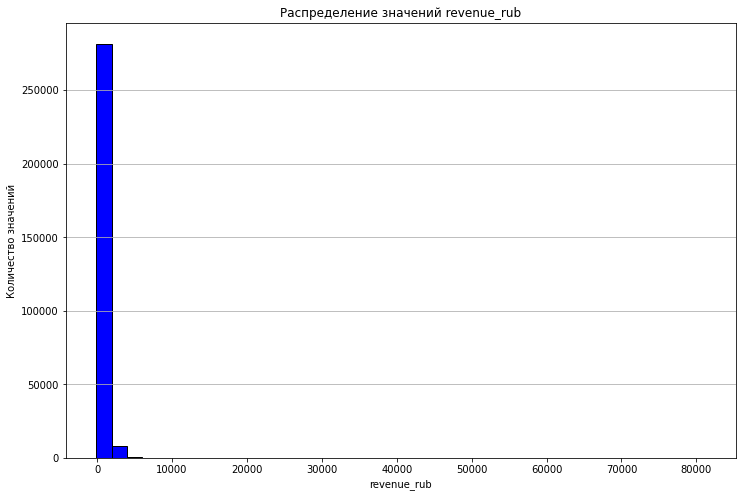

In [30]:
# Построим гистограмму распределения значений revenue_rub
plt.figure(figsize = [12,8])
plt.hist(orders_events_tenge_df['revenue_rub'],
         bins = 40,
         color = 'blue',
         edgecolor = 'black'         
         )
plt.grid(axis= 'y')
plt.title('Распределение значений revenue_rub')
plt.xlabel('revenue_rub')
plt.ylabel('Количество значений')
plt.show()

In [31]:
# Првоерим показатели датафрейма
orders_events_tenge_df['revenue_rub'].describe()

count    290611.000000
mean        555.571987
std         875.498172
min         -90.760000
25%         113.970000
50%         351.140000
75%         802.050000
max       81174.540000
Name: revenue_rub, dtype: float64

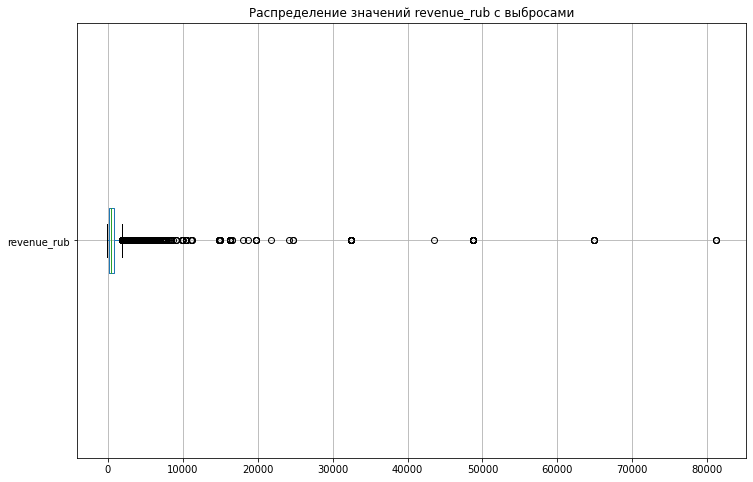

In [32]:
# Построим диаграмму размаха для revenue_rub
plt.figure(figsize = [12,8])
box = orders_events_tenge_df.boxplot(column = 'revenue_rub',
                  vert = False,
                      )
plt.title('Распределение значений revenue_rub с выбросами')

plt.show()

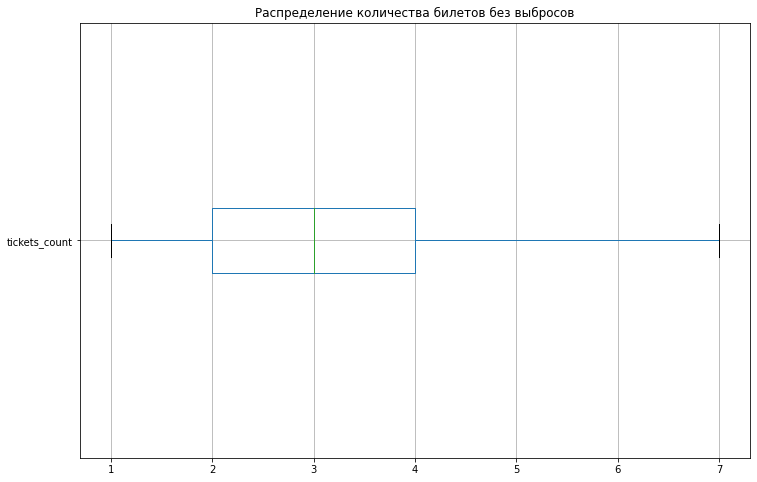

In [33]:
plt.figure(figsize = [12,8])
box = orders_events_tenge_df.boxplot(column = 'tickets_count',
                  vert = False,
                     showfliers = False )
plt.title('Распределение количества билетов без выбросов')

plt.show()

Количестов билетов в заказе варьируется от 1 до 7 штук с медианой 3

In [34]:
# Проверим описание данных
orders_events_tenge_df['revenue_rub'].describe()

count    290611.000000
mean        555.571987
std         875.498172
min         -90.760000
25%         113.970000
50%         351.140000
75%         802.050000
max       81174.540000
Name: revenue_rub, dtype: float64

In [35]:
# Найдем значение 99 процентиля
quantile_99 = round(orders_events_tenge_df['revenue'].quantile(q = 0.99) ,2)
display(quantile_99)

4003.13

In [36]:
# так как в значениях revenue_rub есть выбросы, то оставим только значения <= 99 процентиля 
orders_events_tenge_df = orders_events_tenge_df[orders_events_tenge_df['revenue_rub'] <= quantile_99]
orders_events_tenge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290012 entries, 0 to 290610
Data columns (total 29 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                290012 non-null  int64         
 1   user_id                 290012 non-null  object        
 2   created_dt_msk          290012 non-null  datetime64[ns]
 3   created_ts_msk          290012 non-null  datetime64[ns]
 4   event_id                290012 non-null  int64         
 5   cinema_circuit          290012 non-null  object        
 6   age_limit               290012 non-null  int64         
 7   currency_code           290012 non-null  object        
 8   device_type_canonical   290012 non-null  object        
 9   revenue                 290012 non-null  float64       
 10  service_name            290012 non-null  object        
 11  tickets_count           290012 non-null  int64         
 12  total                   290012

In [37]:
# Проверим максимальное значение в выручке
orders_events_tenge_df['revenue_rub'].max()

4000.19

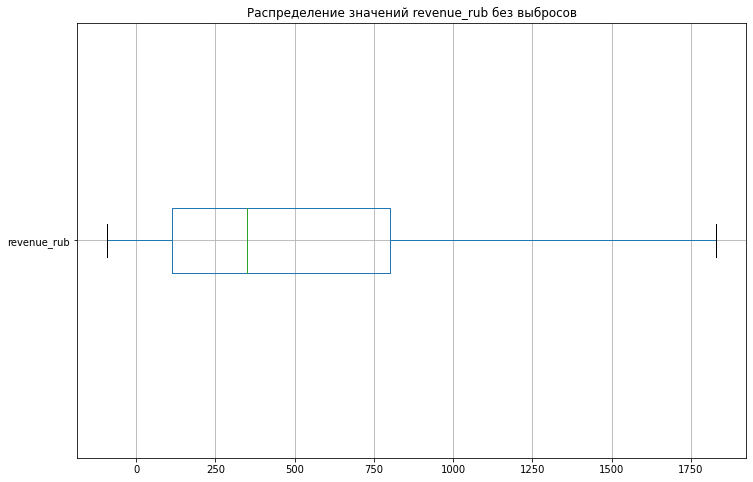

In [38]:
# Построим диаграмму размаха для revenue_rub без выбросов

plt.figure(figsize = [12,8])
box = orders_events_tenge_df.boxplot(column = 'revenue_rub',
                  vert = False,
                      showfliers = False)
plt.title('Распределение значений revenue_rub без выбросов')

plt.show()

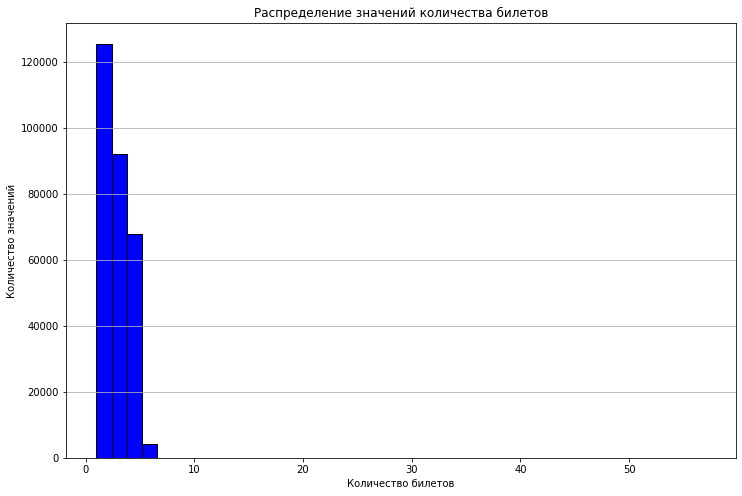

In [39]:
# Построим гистограмму распределения количества билетов
plt.figure(figsize = [12,8])
plt.hist(orders_events_tenge_df['tickets_count'],
         bins = 40,
         color = 'blue',
         edgecolor = 'black'         
         )
plt.grid(axis = 'y')
plt.title('Распределение значений количества билетов')
plt.xlabel('Количество билетов')
plt.ylabel('Количество значений')
plt.show()

В большинстве заказов количество билетов не превышает 10 тысяч

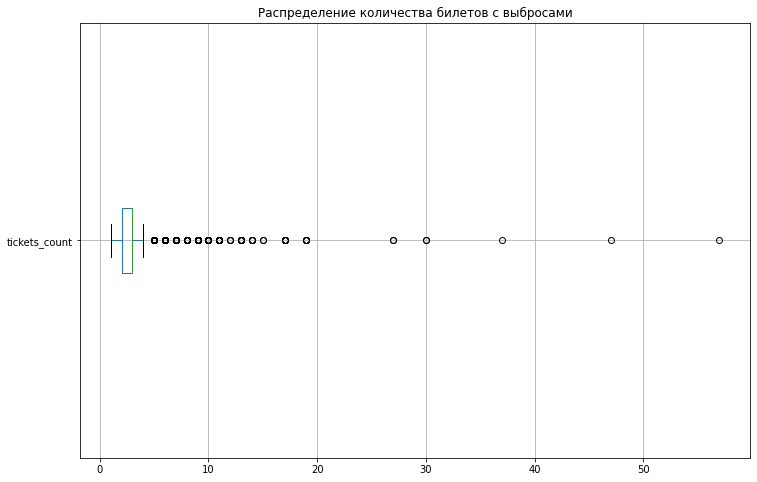

In [40]:
# Построим диаграмму размаха для количества билетов с выбросами

plt.figure(figsize = [12,8])
box = orders_events_tenge_df.boxplot(column = 'tickets_count',
                  vert = False,
                      )
plt.title('Распределение количества билетов с выбросами')

plt.show()

Количество билетов в заказе составляет от 1 до 4 штук

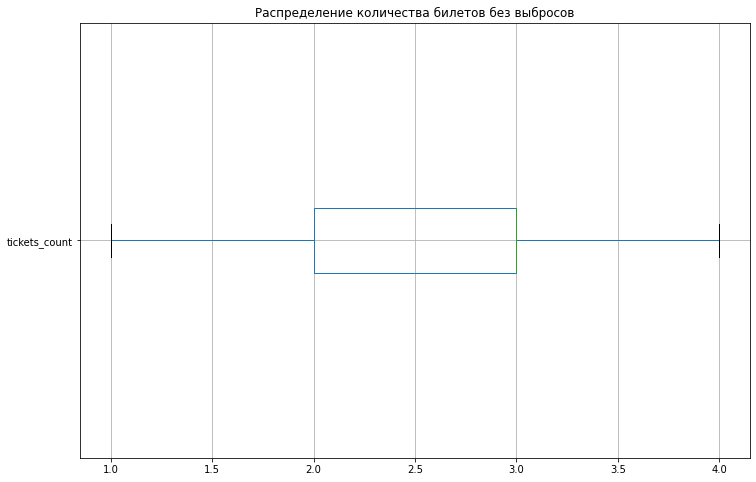

In [41]:
# Посмотрим на распределение количества билетов, после отсечения выбросов revenue_rub
plt.figure(figsize = [12,8])
box = orders_events_tenge_df.boxplot(column = 'tickets_count',
                  vert = False,
                     showfliers = False )
plt.title('Распределение количества билетов без выбросов')

plt.show()

Теперь количество билетов изменилось от 1 до 4, с медианой в 3 штуки

In [42]:
# Проверим наличие явных дубликатов в датафрейме
orders_events_tenge_df.duplicated(subset=None,).sum() 

0

Видим, что явных дубликатов нет

In [43]:
# Получим список столбцов датафрема
orders_events_tenge_df.columns

Index(['order_id', 'user_id', 'created_dt_msk', 'created_ts_msk', 'event_id',
       'cinema_circuit', 'age_limit', 'currency_code', 'device_type_canonical',
       'revenue', 'service_name', 'tickets_count', 'total', 'days_since_prev',
       'event_name', 'event_type_description', 'event_type_main', 'organizers',
       'region_name', 'city_name', 'city_id', 'venue_id', 'venue_name',
       'venue_address', 'data', 'nominal', 'curs', 'cdx', 'revenue_rub'],
      dtype='object')

In [44]:
# Проверим на неявные дубликаты по столбцам
orders_events_tenge_df.duplicated(subset=['user_id', 'created_dt_msk', 'created_ts_msk', 'event_id',
       'cinema_circuit', 'age_limit', 'currency_code', 'device_type_canonical',
       'revenue', 'service_name', 'tickets_count', 'total', 'days_since_prev',
       'event_name', 'event_type_description', 'event_type_main', 'organizers',
       'region_name', 'city_name', 'city_id', 'venue_id', 'venue_name',
       'venue_address', 'data', 'nominal', 'curs', 'cdx', 'revenue_rub'], keep = 'first').sum() 

30

In [45]:
# Удаляем дубликаты
orders_events_tenge_df.drop_duplicates(subset=['user_id', 'created_dt_msk', 'created_ts_msk', 'event_id',
       'cinema_circuit', 'age_limit', 'currency_code', 'device_type_canonical',
       'revenue', 'service_name', 'tickets_count', 'total', 'days_since_prev',
       'event_name', 'event_type_description', 'event_type_main', 'organizers',
       'region_name', 'city_name', 'city_id', 'venue_id', 'venue_name',
       'venue_address', 'data', 'nominal', 'curs', 'cdx', 'revenue_rub'], keep='first', inplace=True)

In [46]:
# Добавим столбец с выручкой, полученной с 1 билета
orders_events_tenge_df['one_ticket_revenue_rub'] = round(orders_events_tenge_df['revenue_rub']/orders_events_tenge_df['tickets_count'] ,2)
orders_events_tenge_df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,city_id,venue_id,venue_name,venue_address,data,nominal,curs,cdx,revenue_rub,one_ticket_revenue_rub
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-08-20,100,18.6972,kzt,1521.94,380.48
1,6274963,44c1c640a242aea,2024-08-20,2024-08-20 22:12:04,237325,нет,0,rub,mobile,144.73,...,213,2941,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",2024-08-20,100,18.6972,kzt,144.73,144.73
2,474528,2b1f730d7024681,2024-08-20,2024-08-20 15:29:56,373657,нет,18,rub,mobile,318.27,...,2,1631,"Музей истории ""Воспоминание"" Групп","наб. Тамбовская, д. 1/4 к. 577",2024-08-20,100,18.6972,kzt,318.27,106.09
3,7477361,05ba93f1b1e1fdd,2024-08-20,2024-08-20 17:06:44,534657,нет,16,rub,mobile,339.61,...,20,2866,"Школа фотографии ""Золотое"" Инк","ш. Микрорайон, д. 79 стр. 50",2024-08-20,100,18.6972,kzt,339.61,339.61
4,472150,3ee7dc2e115847f,2024-08-20,2024-08-20 02:57:22,534657,нет,16,rub,mobile,339.61,...,20,2866,"Школа фотографии ""Золотое"" Инк","ш. Микрорайон, д. 79 стр. 50",2024-08-20,100,18.6972,kzt,339.61,339.61


In [47]:
# Добавим столбец с месяцем, в которым был сделан заказ 
orders_events_tenge_df['month'] = orders_events_tenge_df['created_dt_msk'].dt.month

In [48]:
orders_events_tenge_df['monthname'] = orders_events_tenge_df['created_dt_msk'].dt.month_name()

In [49]:
# Выводим первые стороки для проверки нового столбца

orders_events_tenge_df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,venue_name,venue_address,data,nominal,curs,cdx,revenue_rub,one_ticket_revenue_rub,month,monthname
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-08-20,100,18.6972,kzt,1521.94,380.48,8,August
1,6274963,44c1c640a242aea,2024-08-20,2024-08-20 22:12:04,237325,нет,0,rub,mobile,144.73,...,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",2024-08-20,100,18.6972,kzt,144.73,144.73,8,August
2,474528,2b1f730d7024681,2024-08-20,2024-08-20 15:29:56,373657,нет,18,rub,mobile,318.27,...,"Музей истории ""Воспоминание"" Групп","наб. Тамбовская, д. 1/4 к. 577",2024-08-20,100,18.6972,kzt,318.27,106.09,8,August
3,7477361,05ba93f1b1e1fdd,2024-08-20,2024-08-20 17:06:44,534657,нет,16,rub,mobile,339.61,...,"Школа фотографии ""Золотое"" Инк","ш. Микрорайон, д. 79 стр. 50",2024-08-20,100,18.6972,kzt,339.61,339.61,8,August
4,472150,3ee7dc2e115847f,2024-08-20,2024-08-20 02:57:22,534657,нет,16,rub,mobile,339.61,...,"Школа фотографии ""Золотое"" Инк","ш. Микрорайон, д. 79 стр. 50",2024-08-20,100,18.6972,kzt,339.61,339.61,8,August


In [50]:
# Cоздадим функцию, которая определит сезон в зависимости от месяца
def get_season(month):
    if month in [12, 1, 2]:
        return 'зима'
    elif month in [3, 4, 5]:
        return 'весна'
    elif month in [6, 7, 8]:
        return 'лето'
    else:
        return 'осень'

In [51]:
# Применим созданную ранее функцию и добавим столбец season
orders_events_tenge_df['season'] = orders_events_tenge_df['month'].apply(get_season)

In [52]:
# Выводим первые стороки для проверки

orders_events_tenge_df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,venue_address,data,nominal,curs,cdx,revenue_rub,one_ticket_revenue_rub,month,monthname,season
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,"алл. Машиностроителей, д. 19 стр. 6",2024-08-20,100,18.6972,kzt,1521.94,380.48,8,August,лето
1,6274963,44c1c640a242aea,2024-08-20,2024-08-20 22:12:04,237325,нет,0,rub,mobile,144.73,...,"алл. Шмидта, д. 9 стр. 4",2024-08-20,100,18.6972,kzt,144.73,144.73,8,August,лето
2,474528,2b1f730d7024681,2024-08-20,2024-08-20 15:29:56,373657,нет,18,rub,mobile,318.27,...,"наб. Тамбовская, д. 1/4 к. 577",2024-08-20,100,18.6972,kzt,318.27,106.09,8,August,лето
3,7477361,05ba93f1b1e1fdd,2024-08-20,2024-08-20 17:06:44,534657,нет,16,rub,mobile,339.61,...,"ш. Микрорайон, д. 79 стр. 50",2024-08-20,100,18.6972,kzt,339.61,339.61,8,August,лето
4,472150,3ee7dc2e115847f,2024-08-20,2024-08-20 02:57:22,534657,нет,16,rub,mobile,339.61,...,"ш. Микрорайон, д. 79 стр. 50",2024-08-20,100,18.6972,kzt,339.61,339.61,8,August,лето


In [53]:
# Проверим данные датафрейма
orders_events_tenge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 289982 entries, 0 to 290610
Data columns (total 33 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                289982 non-null  int64         
 1   user_id                 289982 non-null  object        
 2   created_dt_msk          289982 non-null  datetime64[ns]
 3   created_ts_msk          289982 non-null  datetime64[ns]
 4   event_id                289982 non-null  int64         
 5   cinema_circuit          289982 non-null  object        
 6   age_limit               289982 non-null  int64         
 7   currency_code           289982 non-null  object        
 8   device_type_canonical   289982 non-null  object        
 9   revenue                 289982 non-null  float64       
 10  service_name            289982 non-null  object        
 11  tickets_count           289982 non-null  int64         
 12  total                   289982

Были объединены 3 датасета, после фильтрации и обработки данныз мы получили 289982 строк, пропусков нет (кроме одного столбца `days_since_prev`, указанного в задании)

Была проведена работа по конвертации выручки в рубли, так как в датасетах выручка была представлена в двух валютах

Был проверены ключевые показатели на выбросы, также эти выбросы были отфильтрованы с помощью 99-процентиля

Датафреым были проверны на явные и неявные дубликаты. Явных дубликатов обнаружено не было, неявных было 30 штук, они были удалены

Также в объединённый датафрейм были добавлены такие столбцы, как выручка в единой валюте - `revenue_rub`, выручка с продажи одного билета на мероприятие - `one_ticket_revenue_rub`, месяц оформления заказа -  `month` и столбец сезонности - `season`.

## Исследовательский анализ данных

### Анализ распределения заказов по сегментам и их сезонные изменения

#### Количество заказов для каждого месяца

In [54]:
# Рассчитаем количество заказов за каждый месяц
month_orders = orders_events_tenge_df.groupby('monthname')['order_id'].count().sort_values()
month_orders

monthname
June          34434
July          40848
August        44880
September     69795
October      100025
Name: order_id, dtype: int64

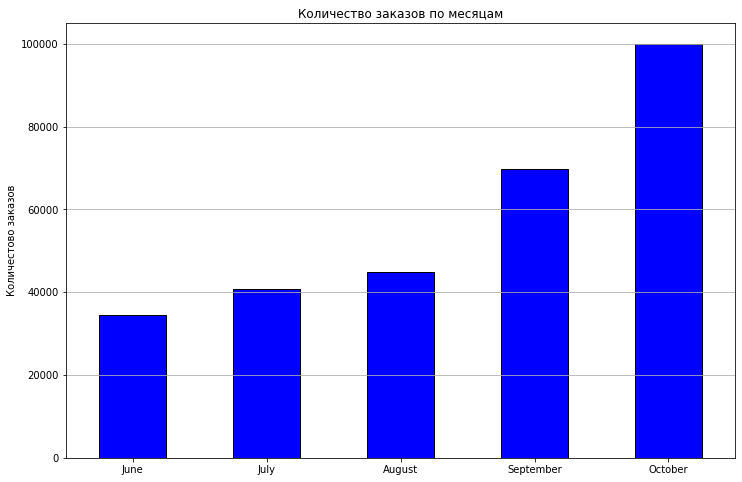

In [55]:
# Визуализируем количество заказов в каждом месяце 
month_orders.plot(kind =  'bar',
              x = 'monthname',
              y = 'count',
             rot = 0,
             figsize = (12,8),
             color = 'blue',
             edgecolor = 'black')
plt.grid(axis = 'y')
plt.xlabel('')
plt.ylabel('Количестово заказов')
plt.title('Количество заказов по месяцам')
plt.show()

По графику видим, что количество заказов растёт от июня к ноябрю 2024 года

#### Распределение заказов билетов для осеннего и летнего периодов по типу мероприятия

In [56]:
# Посмотрим на распределение количества заказов по типам мероприятий 
season_orders = orders_events_tenge_df.groupby(['season','event_type_main'], as_index = False)['order_id'].count()
season_orders

,season,event_type_main,order_id
0,лето,выставки,2416
1,лето,другое,32567
2,лето,концерты,51388
3,лето,спорт,3010
4,лето,стендап,6384
5,лето,театр,24122
6,лето,ёлки,275
7,осень,выставки,2437
8,осень,другое,33286
9,осень,концерты,63575


In [57]:
# Далее рассчитаем доли количества заказов определенного типа мероприятия от общего количества заказов за сезон
events_sum = season_orders.groupby('season')['order_id'].sum()

In [58]:
season_orders['season_total'] = season_orders['season'].map(events_sum)
season_orders

,season,event_type_main,order_id,season_total
0,лето,выставки,2416,120162
1,лето,другое,32567,120162
2,лето,концерты,51388,120162
3,лето,спорт,3010,120162
4,лето,стендап,6384,120162
5,лето,театр,24122,120162
6,лето,ёлки,275,120162
7,осень,выставки,2437,169820
8,осень,другое,33286,169820
9,осень,концерты,63575,169820


In [59]:
# Рассчитаем доли для удобства
season_orders['order_share'] = round(season_orders['order_id']/season_orders['season_total'],3 )
season_orders

,season,event_type_main,order_id,season_total,order_share
0,лето,выставки,2416,120162,0.020
1,лето,другое,32567,120162,0.271
2,лето,концерты,51388,120162,0.428
3,лето,спорт,3010,120162,0.025
4,лето,стендап,6384,120162,0.053
5,лето,театр,24122,120162,0.201
6,лето,ёлки,275,120162,0.002
7,осень,выставки,2437,169820,0.014
8,осень,другое,33286,169820,0.196
9,осень,концерты,63575,169820,0.374


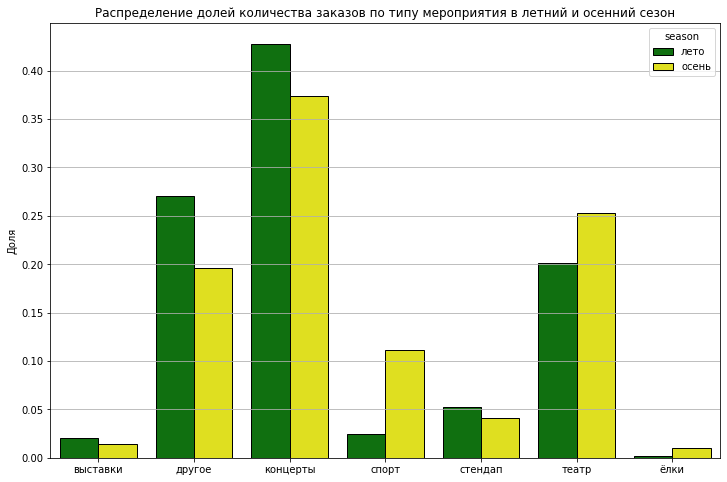

In [60]:
# Строим диаграмму, сравниваем доли количества заказов по типу мероприятия в летний и осенний сезон
plt.figure(figsize = (12, 8)) 
sns.barplot(data = season_orders,
            x = 'event_type_main', 
            y = 'order_share',
            hue = 'season',  
            palette = (['green', 'yellow']),
            edgecolor = 'black'
           )

plt.xlabel('')
plt.ylabel('Доля')
plt.grid(axis = 'y')
plt.title('Распределение долей количества заказов по типу мероприятия в летний и осенний сезон')
plt.show()

In [61]:
# Сравним доли в летний и осенний сезоны
categories =  orders_events_tenge_df.groupby(['season','event_type_main'])['order_id'].count().unstack().T.reset_index()
categories['summer_share'] = round(categories['лето']/categories['лето'].sum() ,3 )
categories['autumn_share'] = round(categories['осень']/categories['осень'].sum(), 3)
categories.sort_values('лето', ascending = False)

season,event_type_main,лето,осень,summer_share,autumn_share
2,концерты,51388,63575,0.428,0.374
1,другое,32567,33286,0.271,0.196
5,театр,24122,42984,0.201,0.253
4,стендап,6384,6944,0.053,0.041
3,спорт,3010,18882,0.025,0.111
0,выставки,2416,2437,0.020,0.014
6,ёлки,275,1712,0.002,0.010


Видим, что популярные меропряития летом и осенью были концерты. Доля концертов летом составлляет 42.8%, осенью 37.4%, видим спад

На втором и третьем месте - другие мероприятия (летом - 27.1%, осенью 19.6%, также видим снижение) и театры (летом - 20.1%, осенью - 25.3%, здесь видим увеличение заказов)

#### Распределение заказов билетов для осеннего и летнего периодов по типу устройства

In [62]:
# Посмотрим на распределение количества заказов по типу устройства 
device_type_orders = orders_events_tenge_df.groupby(['season','device_type_canonical'], as_index = False)['order_id'].count()
device_type_orders

,season,device_type_canonical,order_id
0,лето,desktop,23356
1,лето,mobile,96806
2,осень,desktop,34617
3,осень,mobile,135203


In [63]:
# Далее рассчитаем доли количества заказов определенного типа устройства от общего количества заказов за сезон
device_sum = device_type_orders.groupby('season')['order_id'].sum()

In [64]:
device_type_orders['device_tolal'] = device_type_orders['season'].map(device_sum)
device_type_orders

,season,device_type_canonical,order_id,device_tolal
0,лето,desktop,23356,120162
1,лето,mobile,96806,120162
2,осень,desktop,34617,169820
3,осень,mobile,135203,169820


In [65]:
# Рассчитаем доли для удобства
device_type_orders['device_share'] = round(device_type_orders['order_id']/device_type_orders['device_tolal'],3 )
device_type_orders

,season,device_type_canonical,order_id,device_tolal,device_share
0,лето,desktop,23356,120162,0.194
1,лето,mobile,96806,120162,0.806
2,осень,desktop,34617,169820,0.204
3,осень,mobile,135203,169820,0.796


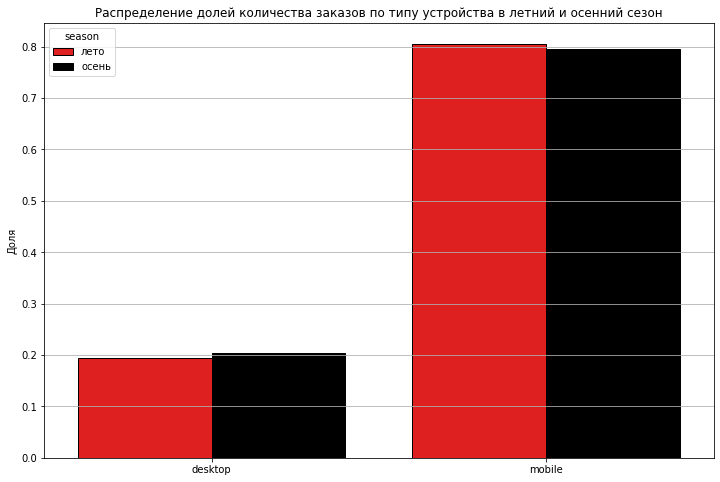

In [66]:
# Строим диаграмму, сравниваем доли количества заказов по типу устройства в летний и осенний сезон
plt.figure(figsize = (12, 8)) 
sns.barplot(data = device_type_orders,
            x = 'device_type_canonical', 
            y = 'device_share',
            hue = 'season',  
            palette = (['red', 'black']),
            edgecolor = 'black'
           )

plt.xlabel('')
plt.ylabel('Доля')
plt.grid(axis = 'y')
plt.title('Распределение долей количества заказов по типу устройства в летний и осенний сезон')
plt.show()

In [67]:
# Сравним доли в летний и осенний сезоны
device_categories =  orders_events_tenge_df.groupby(['season','device_type_canonical'])['order_id'].count().unstack().T.reset_index()
device_categories['summer_share'] = round(device_categories['лето']/device_categories['лето'].sum() ,3 )
device_categories['autumn_share'] = round(device_categories['осень']/device_categories['осень'].sum(), 3)
device_categories.sort_values('лето', ascending = False)

season,device_type_canonical,лето,осень,summer_share,autumn_share
1,mobile,96806,135203,0.806,0.796
0,desktop,23356,34617,0.194,0.204


Видим, что доля заказов превышает с мобильных устройств, но по динамике осенью видим снижение, летом доля была 80.6%, осенью 79.6%
По дексктопным устройствам наоборот, видим увеличение количества заказов, летом 19.4%, осенью - 20.4%

#### Распределение заказов билетов для осеннего и летнего периодов по возрастному рейтингу

In [68]:
# Посмотрим на распределение количества заказов по возрастному рейтингу
age_orders = orders_events_tenge_df.groupby(['season','age_limit'], as_index = False)['order_id'].count()
age_orders

,season,age_limit,order_id
0,лето,0,21608
1,лето,6,21945
2,лето,12,24709
3,лето,16,33937
4,лето,18,17963
5,осень,0,39865
6,осень,6,30174
7,осень,12,37575
8,осень,16,44443
9,осень,18,17763


In [69]:
# Далее рассчитаем доли количества заказов по возрастному рейтингу от общего количества заказов за сезон
age_sum = age_orders.groupby('season')['order_id'].sum()

In [70]:
age_orders['age_tolal'] = age_orders['season'].map(age_sum)
age_orders

,season,age_limit,order_id,age_tolal
0,лето,0,21608,120162
1,лето,6,21945,120162
2,лето,12,24709,120162
3,лето,16,33937,120162
4,лето,18,17963,120162
5,осень,0,39865,169820
6,осень,6,30174,169820
7,осень,12,37575,169820
8,осень,16,44443,169820
9,осень,18,17763,169820


In [71]:
# Рассчитаем доли для удобства
age_orders['age_share'] = round(age_orders['order_id']/age_orders['age_tolal'],3 )
age_orders

,season,age_limit,order_id,age_tolal,age_share
0,лето,0,21608,120162,0.180
1,лето,6,21945,120162,0.183
2,лето,12,24709,120162,0.206
3,лето,16,33937,120162,0.282
4,лето,18,17963,120162,0.149
5,осень,0,39865,169820,0.235
6,осень,6,30174,169820,0.178
7,осень,12,37575,169820,0.221
8,осень,16,44443,169820,0.262
9,осень,18,17763,169820,0.105


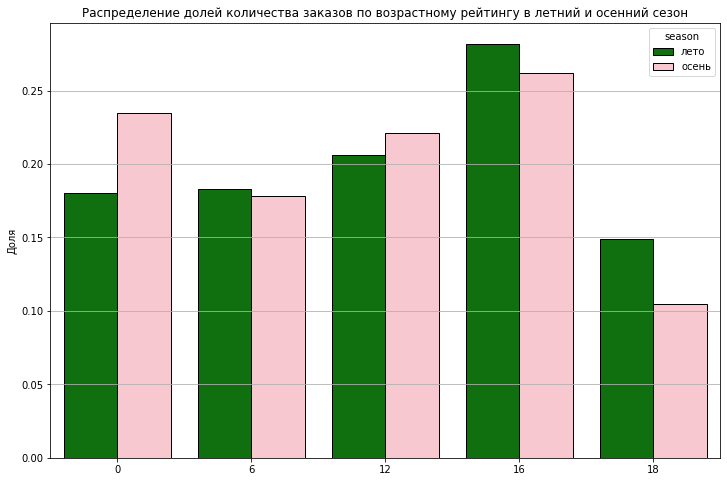

In [72]:
# Строим диаграмму, сравниваем доли количества заказов по возрастному рейтингу в летний и осенний сезон
plt.figure(figsize = (12, 8)) 
sns.barplot(data = age_orders,
            x = 'age_limit', 
            y = 'age_share',
            hue = 'season',  
            palette = (['green', 'pink']),
            edgecolor = 'black'
           )

plt.xlabel('')
plt.ylabel('Доля')
plt.grid(axis = 'y')
plt.title('Распределение долей количества заказов по возрастному рейтингу в летний и осенний сезон')
plt.show()

In [73]:
# Сравним доли в летний и осенний сезоны
age_limits =  orders_events_tenge_df.groupby(['season','age_limit'])['order_id'].count().unstack().T.reset_index()
age_limits['summer_share'] = round(age_limits['лето']/age_limits['лето'].sum() ,3 )
age_limits['autumn_share'] = round(age_limits['осень']/age_limits['осень'].sum(), 3)
age_limits.sort_values('лето', ascending = False)

season,age_limit,лето,осень,summer_share,autumn_share
3,16,33937,44443,0.282,0.262
2,12,24709,37575,0.206,0.221
1,6,21945,30174,0.183,0.178
0,0,21608,39865,0.180,0.235
4,18,17963,17763,0.149,0.105


На первом месте находятся мероприятия для возраста 16 лет, летом количество заказов составляло 28.2%, осенью видим снижение - 26.2%

На втором месте мероприятия для 12-ти лет, летом 20.6%, осенью же увеличение количества заказов - 22.1%

На третьем и четвёртом месте мероприятия для 0 и для 18-летних пользователей, повышение для 0: летом - 18%, осенью - 23.5% и для 18-ти лет: летом 14.9% и 10.5% соответственно

#### Изменение выручки с продажи одного билета

In [74]:
# Посчитаем среднюю выручку с 1 билета в каждой категории мероприятий летом и осенью
avg_revenue_per_ticket = round(orders_events_tenge_df.groupby(['season','event_type_main'], as_index = False)['revenue_rub'].mean(),2)
avg_revenue_per_ticket

,season,event_type_main,revenue_rub
0,лето,выставки,228.38
1,лето,другое,245.97
2,лето,концерты,826.74
3,лето,спорт,151.47
4,лето,стендап,660.57
5,лето,театр,601.94
6,лето,ёлки,822.19
7,осень,выставки,237.39
8,осень,другое,230.35
9,осень,концерты,736.76


In [75]:
# Посчитаем в долях для построения диаграммы
ticket_sum = avg_revenue_per_ticket.groupby('season')['revenue_rub'].sum()

avg_revenue_per_ticket['sums'] = avg_revenue_per_ticket['season'].map(ticket_sum)

avg_revenue_per_ticket['share'] = round(avg_revenue_per_ticket['revenue_rub']/avg_revenue_per_ticket['sums'] , 3)
avg_revenue_per_ticket

,season,event_type_main,revenue_rub,sums,share
0,лето,выставки,228.38,3537.26,0.065
1,лето,другое,245.97,3537.26,0.070
2,лето,концерты,826.74,3537.26,0.234
3,лето,спорт,151.47,3537.26,0.043
4,лето,стендап,660.57,3537.26,0.187
5,лето,театр,601.94,3537.26,0.170
6,лето,ёлки,822.19,3537.26,0.232
7,осень,выставки,237.39,3300.20,0.072
8,осень,другое,230.35,3300.20,0.070
9,осень,концерты,736.76,3300.20,0.223


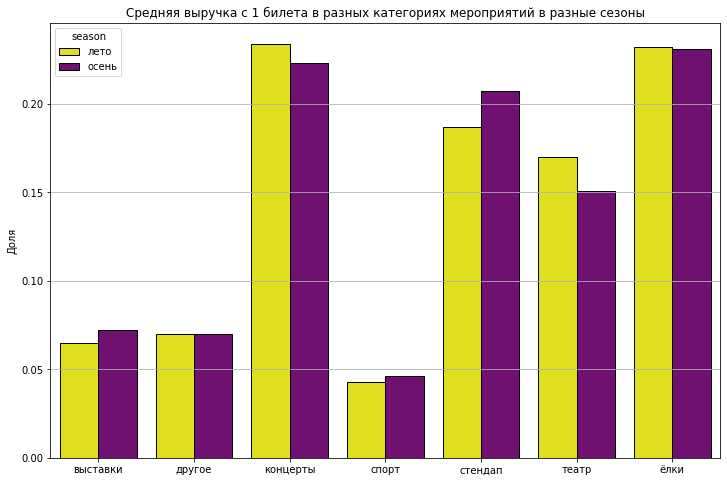

In [76]:
plt.figure(figsize = (12, 8)) 
sns.barplot(data = avg_revenue_per_ticket,
            x = 'event_type_main', 
            y = 'share',
            hue = 'season',  
            palette = (['yellow', 'purple']),
            edgecolor = 'black'       
           )

plt.xlabel('')
plt.ylabel('Доля')
plt.grid(axis = 'y')
plt.title('Средняя выручка с 1 билета в разных категориях мероприятий в разные сезоны')
plt.show()

In [77]:
# Найдем  изменение выручки с 1 билета осенью в сравнении с летом
change = orders_events_tenge_df.groupby(['season','event_type_main'])['revenue_rub'].mean().unstack().T.reset_index()
change ['diff'] =  round(change ['осень'] - change ['лето'] ,2 )  
change ['rel'] = round(change ['diff']/change ['лето'] , 3)  
change

season,event_type_main,лето,осень,diff,rel
0,выставки,228.381672,237.394592,9.01,0.039
1,другое,245.974819,230.350079,-15.62,-0.064
2,концерты,826.740986,736.758622,-89.98,-0.109
3,спорт,151.471807,153.329161,1.86,0.012
4,стендап,660.565123,684.184633,23.62,0.036
5,театр,601.938994,497.278069,-104.66,-0.174
6,ёлки,822.187782,760.905076,-61.28,-0.075


По данным средня выручка возросла с 1 билета в категориях выставки(+3.9%), спорт(+1,2%), стендап(3,6%)

Средняя выручка снизилась в категориях другое(-6,4%), концерты(-10,9%), театр(-17,4%), ёлки(-7,5%)

Мы можем заметить рост количества заказов осенью по сравнению с летним периодом

### Осенняя активность пользователей

#### Динамика изменений по дням

In [78]:
# В отдельный датафрейм вынесем осень
autumn_df = orders_events_tenge_df[orders_events_tenge_df['season'] == 'осень']
autumn_df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,venue_address,data,nominal,curs,cdx,revenue_rub,one_ticket_revenue_rub,month,monthname,season
8058,4222372,0beb8fc0c0a9ce1,2024-10-21,2024-10-21 14:14:26,169230,нет,16,rub,mobile,1521.94,...,"алл. Машиностроителей, д. 19 стр. 6",2024-10-21,100,19.7884,kzt,1521.94,380.48,10,October,осень
8059,3188290,fc950d43881de43,2024-10-21,2024-10-21 21:42:42,169230,нет,16,rub,mobile,1141.45,...,"алл. Машиностроителей, д. 19 стр. 6",2024-10-21,100,19.7884,kzt,1141.45,380.48,10,October,осень
8060,2217370,b11294e5f3e6da6,2024-10-21,2024-10-21 14:05:34,237325,нет,0,rub,mobile,289.45,...,"алл. Шмидта, д. 9 стр. 4",2024-10-21,100,19.7884,kzt,289.45,144.72,10,October,осень
8061,7926136,b5ecbee7c8fe379,2024-10-21,2024-10-21 21:36:31,237325,нет,0,rub,mobile,434.18,...,"алл. Шмидта, д. 9 стр. 4",2024-10-21,100,19.7884,kzt,434.18,144.73,10,October,осень
8062,7453001,c87b8d1ab30ce07,2024-10-21,2024-10-21 10:19:19,578454,нет,0,rub,mobile,1258.57,...,"алл. Юбилейная, д. 5/6",2024-10-21,100,19.7884,kzt,1258.57,314.64,10,October,осень


In [79]:
# Построим сводную таблицу 
table =  autumn_df.pivot_table(index = 'created_dt_msk',
                           values = ['order_id', 'user_id', 'revenue_rub'],
                           aggfunc = {'order_id': 'count', 'user_id': 'nunique','revenue_rub' : 'mean'})

table['orders_per_user'] = round(table['order_id']/ table['user_id'] ,2)
table['revenue_rub'] = table['revenue_rub'].round()
table

,order_id,revenue_rub,user_id,orders_per_user
created_dt_msk,,,,
2024-09-01,1346,580.0,569,2.37
2024-09-02,1388,525.0,578,2.40
2024-09-03,5120,230.0,782,6.55
2024-09-04,1780,495.0,688,2.59
2024-09-05,1957,526.0,744,2.63
...,...,...,...,...
2024-10-27,2864,525.0,1037,2.76
2024-10-28,2851,489.0,987,2.89
2024-10-29,2886,517.0,1002,2.88


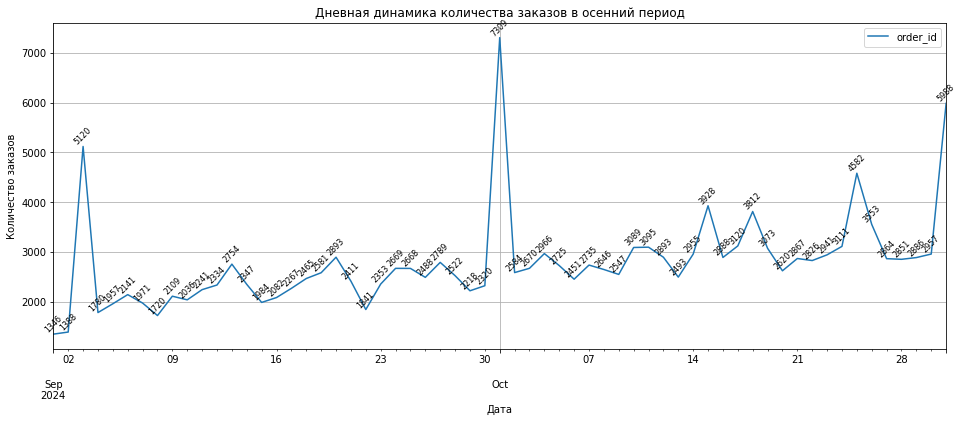

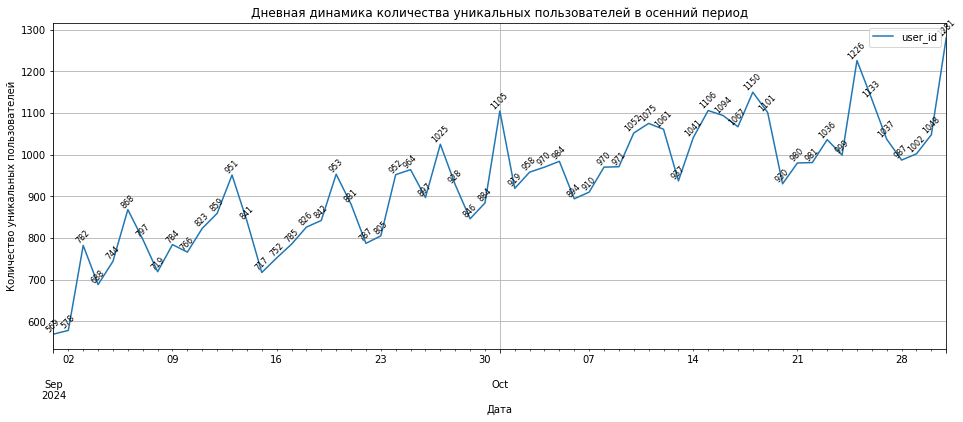

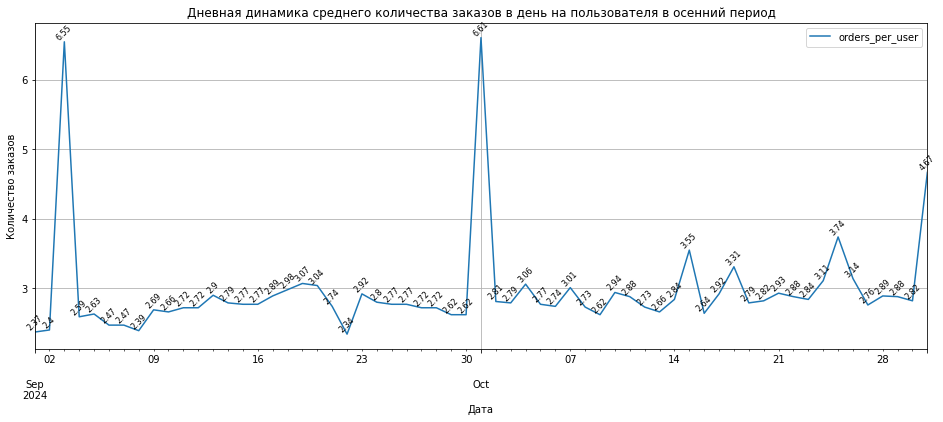

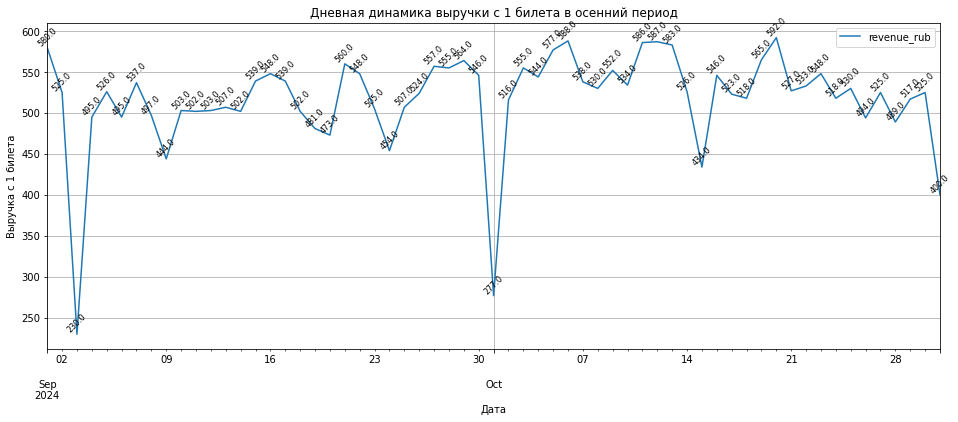

In [80]:
table.plot(kind = 'line',
          y = 'order_id',
           figsize = (16,6))

# Добавляем подписи значений
for x, y in zip(table.index, table['order_id']):
    plt.text(x, y, f'{y}', 
             ha='center',  # выравнивание по горизонтали
             va='bottom',  # выравнивание по вертикали
             rotation=45,  # поворот текста
             fontsize=8)

plt.grid()
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.title('Дневная динамика количества заказов в осенний период')
plt.show()

####

table.plot(kind = 'line',
          y = 'user_id',
           figsize = (16,6))

# Добавляем подписи значений
for x, y in zip(table.index, table['user_id']):
    plt.text(x, y, f'{y}', 
             ha='center',  # выравнивание по горизонтали
             va='bottom',  # выравнивание по вертикали
             rotation=45,  # поворот текста
             fontsize=8)

plt.grid()
plt.xlabel('Дата')
plt.ylabel('Количество уникальных пользователей')
plt.title('Дневная динамика количества уникальных пользователей в осенний период')
plt.show()

####


table.plot(kind = 'line',
          y = 'orders_per_user',
           figsize = (16,6))

# Добавляем подписи значений
for x, y in zip(table.index, table['orders_per_user']):
    plt.text(x, y, f'{y}', 
             ha='center',  # выравнивание по горизонтали
             va='bottom',  # выравнивание по вертикали
             rotation=45,  # поворот текста
             fontsize=8)

plt.grid()
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.title('Дневная динамика среднего количества заказов в день на пользователя в осенний период')
plt.show()

####

table.plot(kind = 'line',
          y = 'revenue_rub',
           figsize = (16,6))

# Добавляем подписи значений
for x, y in zip(table.index, table['revenue_rub']):
    plt.text(x, y, f'{y}', 
             ha='center',  # выравнивание по горизонтали
             va='bottom',  # выравнивание по вертикали
             rotation=45,  # поворот текста
             fontsize=8)

plt.grid()
plt.xlabel('Дата')
plt.ylabel('Выручка с 1 билета')
plt.title('Дневная динамика выручки с 1 билета в осенний период')
plt.show()

**Общее количество заказов в день:** видим пики продаж в начале сентября, в конце сентября-начале октября и в конце октября, получается, что пики по количествам наблюдаются в начале и в конце месяца

**Количество активных пользователей DAU:** здесь видим стабильное повышение активных пользователей с начала осени и по конец октября

**Среднее число заказов на одного пользователя:** график идентичен данным графика общего количества заказов в день, пики высокого показателя приходятся на начало и конец месяцев

**Средняя стоимость одного билета:** дневная выручка с 1 билета в пиковые дни продаж низкая и она полностью совпадает с пиками высокого количества заказов, скорее всего это обусловлено тем, что в эти дни проходят акции и билеты продаются по сниженным ценам (знаю, что такие акции есть в некоторых кинотеатрах, напимер есть акция по вторникам, когда билеты на 50% дешевле обычной стоимости и по средам также в некоторых кинотеатрах наблюдала такие акционные предложения)

#### Недельная цикличность

In [81]:
# Добавим столбец,в котором выделим день недели day of week
autumn_df['day_of_week'] = autumn_df['created_dt_msk'].dt.weekday

/tmp/ipykernel_31/3037339460.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  autumn_df['day_of_week'] = autumn_df['created_dt_msk'].dt.weekday


In [82]:
#Создадим функцию, которая присвоит названия номерам дня недели,
# и добавим название дня недели как новый столбец
def day_of_weekname(day_of_week):  
    if day_of_week == 0:
        return 'Понедельник'
    elif day_of_week == 1:  
        return 'Вторник'
    elif day_of_week == 2:
        return 'Среда'
    elif day_of_week == 3:
        return 'Четверг'
    elif day_of_week == 4:
        return 'Пятница'
    elif day_of_week == 5:
        return 'Суббота'
    else:
        return 'Воскресенье'
    
autumn_df['day_of_week_name'] = autumn_df['day_of_week'].apply(day_of_weekname) 
autumn_df.sample(7)

/tmp/ipykernel_31/2144430128.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  autumn_df['day_of_week_name'] = autumn_df['day_of_week'].apply(day_of_weekname)


,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,nominal,curs,cdx,revenue_rub,one_ticket_revenue_rub,month,monthname,season,day_of_week,day_of_week_name
24469,571968,b9fbc0df8f0f203,2024-10-24,2024-10-24 19:21:41,294473,нет,16,rub,mobile,831.88,...,100,19.9587,kzt,831.88,277.29,10,October,осень,3,Четверг
233518,1095070,2564e3703075008,2024-09-05,2024-09-05 17:27:54,461844,нет,16,rub,mobile,58.57,...,100,18.4217,kzt,58.57,14.64,9,September,осень,3,Четверг
77536,3496763,baa9150d3e7cc39,2024-10-20,2024-10-20 14:03:34,319992,нет,0,rub,mobile,113.71,...,100,19.7884,kzt,113.71,37.90,10,October,осень,6,Воскресенье
66118,4896390,8d6c1ff89fac35f,2024-10-31,2024-10-31 21:29:25,589624,нет,16,rub,desktop,125.49,...,100,19.7383,kzt,125.49,41.83,10,October,осень,3,Четверг
57482,4901494,6c53f4c1f1210cc,2024-10-17,2024-10-17 13:22:27,161434,нет,12,rub,mobile,84.64,...,100,19.9534,kzt,84.64,28.21,10,October,осень,3,Четверг
35495,6480196,2a92d67b4597d1c,2024-10-30,2024-10-30 08:23:51,583621,нет,0,rub,mobile,36.36,...,100,19.9516,kzt,36.36,12.12,10,October,осень,2,Среда
212922,2131704,4c96e2a46134b1c,2024-10-15,2024-10-15 20:27:04,579028,нет,16,rub,mobile,473.82,...,100,19.7185,kzt,473.82,236.91,10,October,осень,1,Вторник


In [83]:
# Создадим таблицу данные о пользовательской активности в каждый из дней недели
table2  = autumn_df.groupby('day_of_week_name').agg({'order_id': 'count',
                                          'user_id' : 'nunique',
                                          'revenue_rub' : 'mean'}).sort_values(by = 'day_of_week_name')
# Переставим дни недели в правильном порядке 
days_order = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
table2 = table2.reindex(days_order)
table2

,order_id,user_id,revenue_rub
day_of_week_name,,,
Понедельник,21660,4468,516.702127
Вторник,31687,4813,402.650112
Среда,23071,4845,523.410470
Четверг,27338,4992,494.370757
Пятница,25032,4889,527.534916
Суббота,21495,4594,546.574329
Воскресенье,19537,4409,558.636429


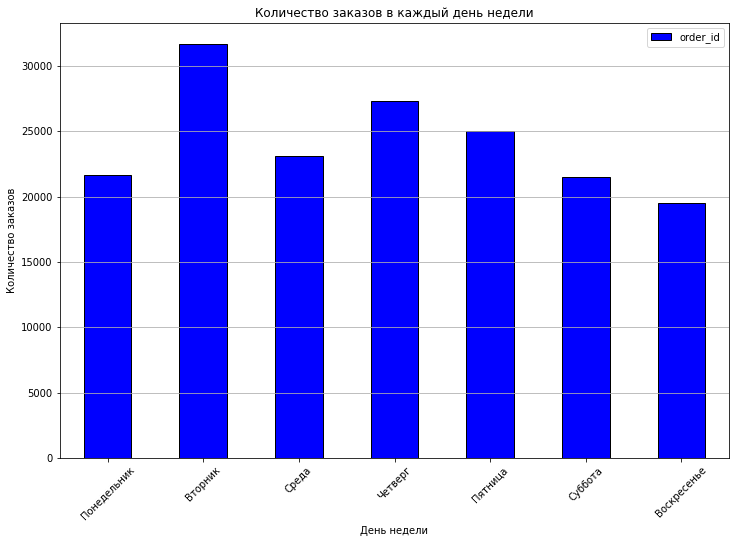

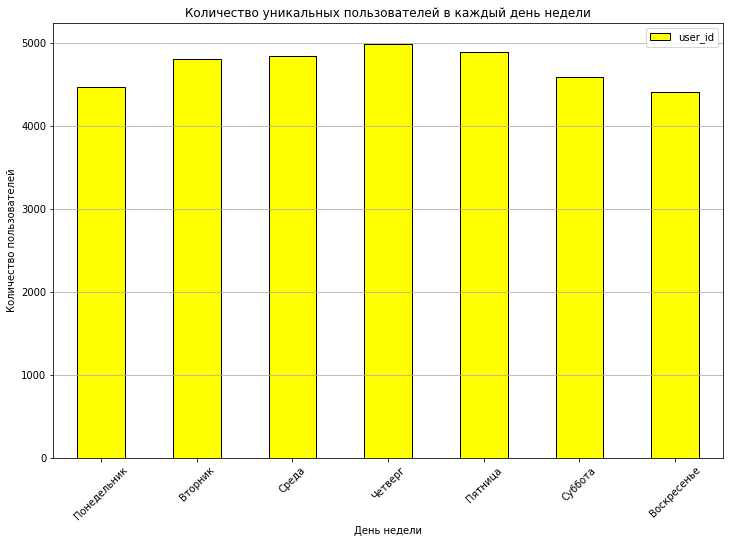

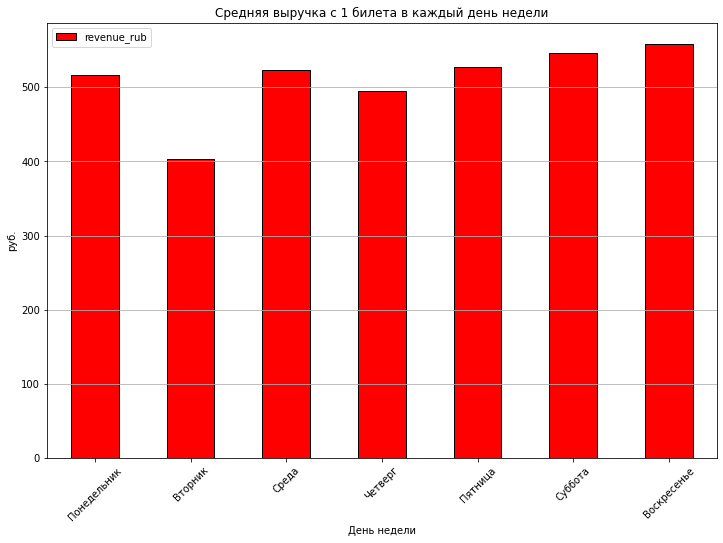

In [84]:
table2['order_id'].plot(kind =  'bar',
             rot = 45,
             figsize = (12,8),
             color = 'blue',
             edgecolor = 'black')

plt.grid(axis = 'y')
plt.xlabel('День недели')
plt.ylabel('Количество заказов')
plt.legend()
plt.title('Количество заказов в каждый день недели')
plt.show()

###

table2['user_id'].plot(kind =  'bar',
             rot = 45,
             figsize = (12,8),
             color = 'yellow',
             edgecolor = 'black')

plt.grid(axis = 'y')
plt.xlabel('День недели')
plt.ylabel('Количество пользователей')
plt.legend()
plt.title('Количество уникальных пользователей в каждый день недели')
plt.show() 

###

table2['revenue_rub'].plot(kind =  'bar',
             rot = 45,
             figsize = (12,8),
             color = 'red',
             edgecolor = 'black')

plt.grid(axis = 'y')
plt.xlabel('День недели')
plt.ylabel('руб.')
plt.legend()
plt.title('Средняя выручка с 1 билета в каждый день недели')
plt.show() 

**Количество заказов:** видим, что наиболее высокие показатели по количеству по вторникам, четвергам и пятницам; снижение заметно на выходных

**Количество активных пользователей DAU:** график отличается не слишклм сильно, на первом месте - четверг, после пятница, в остальные дни значения практически равны

**Средняя выручка с одного билета:** данные примерно равны, но видим сильное снижение по вторникам, в остальные дни данные находятся практически на одном уровне

### Популярные события и партнёры

In [85]:
# Проверим уникальные значения по регионам
orders_events_tenge_df['region_name'].sort_values().unique()

array(['Белоярская область', 'Берестовский округ', 'Берёзовская область',
       'Боровлянский край', 'Верховинская область', 'Верхозёрский край',
       'Верхоречная область', 'Ветренский регион', 'Вишнёвский край',
       'Глиногорская область', 'Голубевский округ',
       'Горицветская область', 'Горноземский регион',
       'Горностепной регион', 'Дальнеземская область',
       'Дальнезорский край', 'Дубравная область', 'Залесский край',
       'Заречная область', 'Зеленоградский округ', 'Златопольский округ',
       'Золотоключевской край', 'Зоринский регион', 'Каменевский регион',
       'Каменичская область', 'Каменноозёрный край', 'Каменноярский край',
       'Каменополянский округ', 'Ключеводский округ',
       'Кристаловская область', 'Кристальная область',
       'Крутоводская область', 'Крутоводский регион', 'Лесноярский край',
       'Лесодальний край', 'Лесополянская область', 'Лесостепной край',
       'Лесоярская область', 'Луговая область', 'Лугоградская область',
    

In [86]:
# В отдельную таблицу соберем данные о регионах, сгруппируем их
regions = orders_events_tenge_df.groupby('region_name').agg({'event_id' : 'nunique',
                                      'order_id' : 'count'})
regions = regions.reset_index()
regions

,region_name,event_id,order_id
0,Белоярская область,57,199
1,Берестовский округ,39,395
2,Берёзовская область,166,1282
3,Боровлянский край,97,1721
4,Верховинская область,8,46
...,...,...,...
76,Шанырский регион,28,2879
77,Широковская область,1233,16446
78,Яблоневская область,535,6173
79,Ягодиновская область,120,1044


In [87]:
# Создадим столбцы, где рассчитаем доли каждого региона от общего количестова событий и заказов 
# Отсортируем по убыванию количества доли прибыли
regions['event_share'] = round(regions['event_id']/ regions['event_id'].sum() ,3 ) 
regions['order_share'] = round(regions['order_id']/ regions['order_id'].sum() ,3 )
regions = regions.sort_values(by = ['event_id', 'order_id'], ascending = [False,False])
regions
regions.sort_values(by = 'order_share', ascending = False)

,region_name,event_id,order_id,event_share,order_share
23,Каменевский регион,5966,90669,0.266,0.313
60,Североярская область,3809,43966,0.170,0.152
77,Широковская область,1233,16446,0.055,0.057
42,Медовская область,504,13898,0.022,0.048
45,Озернинский край,349,10476,0.016,0.036
...,...,...,...,...,...
51,Радужнопольский край,13,139,0.001,0.000
70,Тихогорская область,14,48,0.001,0.000
16,Дубравная область,16,67,0.001,0.000
35,Лесополянская область,18,87,0.001,0.000


In [88]:
# Выберем регионы, в которых проведено более 500 мероприятий
regions_top = regions[regions['order_share'] > 0.01]
regions_top

,region_name,event_id,order_id,event_share,order_share
23,Каменевский регион,5966,90669,0.266,0.313
60,Североярская область,3809,43966,0.170,0.152
77,Широковская область,1233,16446,0.055,0.057
57,Светополянский округ,1075,7575,0.048,0.026
52,Речиновская область,702,6290,0.031,0.022
74,Травяная область,683,5042,0.030,0.017
11,Горицветская область,551,5162,0.025,0.018
61,Серебринская область,541,5608,0.024,0.019
78,Яблоневская область,535,6173,0.024,0.021
69,Тепляковская область,529,4387,0.024,0.015


In [89]:
regions_all = len(regions)
reg_top = len(regions_top)
reg_top_percentage = round(regions_top['order_share'].sum() ,3)
print(f'Из {regions_all} регионов {reg_top}  приносят более 1% выручки.'
f'Суммарная выручка данных регионов составляет {100 * reg_top_percentage} %')

Из 81 регионов 18  приносят более 1% выручки.Суммарная выручка данных регионов составляет 84.1 %


In [90]:
# Соберем данные о билетных операторах, сгруппируем ее
services  = orders_events_tenge_df.groupby('service_name').agg({'event_id' : 'nunique',
                                                    'order_id' : 'count',
                                                    'revenue_rub' : 'sum'})
services = services.reset_index()
# Создадим столбцы, где рассчитаем доли каждого оператора от общего количестова событий, заказов, выручки 
# Отсортируем по убыванию процента выручки
services['event_share'] = round(services['event_id']/ services['event_id'].sum() ,3 ) 
services['order_share'] = round(services['order_id']/ services['order_id'].sum() ,3 )
services['revenue_rub'] = round(services['revenue_rub'] ,2 )
# Посчитаем,какой процент выручки приносит каждый из билетных операторов
services['revenue_share'] = round(services['revenue_rub']/ services['revenue_rub'].sum() ,3)
services = services.sort_values(by = ['event_id', 'order_id'], ascending = [False,False])

services = services.sort_values(by = 'revenue_share', ascending = False)

In [91]:
# Отберем билетных партнеров, которые приносят более 1% от общей выручки

services_top = services[services['revenue_share'] > 0.01]
services_top

,service_name,event_id,order_id,revenue_rub,event_share,order_share,revenue_share
3,Билеты без проблем,4253,63391,25883328.06,0.174,0.219,0.166
24,Мой билет,1306,34751,22975601.44,0.053,0.120,0.147
25,Облачко,2343,26557,19041296.87,0.096,0.092,0.122
21,Лови билет!,4878,41104,17573375.71,0.200,0.142,0.113
8,Весь в билетах,864,16728,17433448.77,0.035,0.058,0.112
5,Билеты в руки,3536,40330,13341168.49,0.145,0.139,0.086
19,Край билетов,252,6195,6653104.66,0.010,0.021,0.043
26,Прачечная,1027,10273,4900985.27,0.042,0.035,0.031
13,Дом культуры,274,4477,4549880.81,0.011,0.015,0.029
35,Яблоко,715,5038,3966818.61,0.029,0.017,0.025


In [92]:
services_all = len(services)
serv_top = len(services_top)
serv_top_percentage = round(services_top['order_share'].sum() ,3)
print(f'Из {services_all} билетных партнеров {serv_top}  приносят более 1% выручки.'
f'Суммарная выручка данных билетных партнеров составляет {100 * serv_top_percentage} % от общего объема выручки')

Из 36 билетных партнеров 16  приносят более 1% выручки.Суммарная выручка данных билетных партнеров составляет 97.0 % от общего объема выручки


Анализ показал неравномерное распределение событий и заказов по регионам

Лидером по количеству заказов является Каменевский регион — на него приходится 31,2 % всех заказов

Далее идут Североярская область (15,2 %) и Широковская область (5,6 %)

Доля заказов из остальных регионов не превышает 3 %

Что касается билетных партнёров, то здесь тоже наблюдается неравномерное распределение выручки. Самые крупные доли рынка занимают:
* «Билеты без проблем» — 16,6 %;
* «Мой билет» — 14,7 %;
* «Облачко» — 12,2 %;
* «Лови билет!» — 11,3 %;
* «Весь в билетах» — 11,2 %

Ещё три компании приносят от 3 % до 9 % выручки, а доля остальных партнёров — менее 3 %. Таким образом, распределение заказов, пользователей и выручки между билетными партнёрами неоднородно

## Статистический анализ данных

### Среднее количество заказов

Мы работаем только с данными за осенний период

Сформулируем основную и альтернативную гипотезы: 

**H0:** Среднее количество заказов на 1 пользователя мобильного приложения не больше по сравнению с пользователями стационарных устройств


**H1:** Среднее количество заказов на 1 пользователя мобильного приложения больше по сравнению с пользователями стационарных устройств

In [93]:
# Используем осенний датафрейм
autumn_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169820 entries, 8058 to 269637
Data columns (total 35 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                169820 non-null  int64         
 1   user_id                 169820 non-null  object        
 2   created_dt_msk          169820 non-null  datetime64[ns]
 3   created_ts_msk          169820 non-null  datetime64[ns]
 4   event_id                169820 non-null  int64         
 5   cinema_circuit          169820 non-null  object        
 6   age_limit               169820 non-null  int64         
 7   currency_code           169820 non-null  object        
 8   device_type_canonical   169820 non-null  object        
 9   revenue                 169820 non-null  float64       
 10  service_name            169820 non-null  object        
 11  tickets_count           169820 non-null  int64         
 12  total                   169

In [94]:
# Сгруппируем данные по  типу устройства
orders = autumn_df.groupby(['user_id','device_type_canonical'])['order_id'].nunique().reset_index()

In [95]:
# Разделим пользователей на 2 группы - по признаку устройства
mobile = orders[orders['device_type_canonical'] == 'mobile']
desktop = orders[orders['device_type_canonical'] == 'desktop']

In [96]:
# Найдем средние значения
avg_mobile_orders = mobile['order_id'].sum()/mobile['user_id'].nunique()
avg_desktop_orders = desktop['order_id'].sum()/desktop['user_id'].nunique()
print(f'Среднее кол-во заказов на 1 пользователя мобильного приложения  {avg_mobile_orders}')
print(f'Среднее кол-во заказов на 1 пользователя десктопа  {avg_desktop_orders}')

Среднее кол-во заказов на 1 пользователя мобильного приложения  9.50193267271066
Среднее кол-во заказов на 1 пользователя десктопа  7.069021850112314


Разница среди пользователей есть, найдём причину этой разницы

In [97]:
# Проверим разделение по количеству заказов устройства mobile
mobile['order_id'].describe()

count    14229.000000
mean         9.501933
std         68.381681
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max       4361.000000
Name: order_id, dtype: float64

In [98]:
# Проверим разделение по количеству заказов устройства desktop
desktop['order_id'].describe()

count    4897.000000
mean        7.069022
std        36.186903
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max      1510.000000
Name: order_id, dtype: float64

Так как есть эктсремальные значения, используем тест Манна-Уитни

In [99]:
# Выборка целевой метрики для группы A
metric_a = mobile['order_id']
# Выборка целевой метрики для группы B
metric_b = desktop['order_id']

# На каком уровне значимости проверяем гипотезу о равенстве распределений
alpha = 0.05 

# Применяем тест Манна — Уитни
stat_mw, p_value_mw = mannwhitneyu(
    metric_a, 
    metric_b, 
    alternative='greater' # Альтернативная гипотеза односторонняя
) 

if p_value_mw > alpha:
    print(f'pvalue={p_value_mw} > {alpha}')
    print('Нулевая гипотеза находит подтверждение!')
    print('Среднее количество заказов на 1 пользователя мобильного приложения не больше в сравнении с пользователями десктопов!')
else:
    print(f'pvalue={p_value_mw} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!')
    print('Среднее количество заказов на 1 пользователя мобильного приложения больше в сравнении с пользователями десктопов!')

pvalue=1.7143741813128202e-07 < 0.05
Нулевая гипотеза не находит подтверждения!
Среднее количество заказов на 1 пользователя мобильного приложения больше в сравнении с пользователями десктопов!


Исходя из полученного результата, делаем вывод, что нулевая гипотеза не подтверждена и пользователи мобильных устройств в среднем делают больше заказов, чем пользователи десктопных устройств

### Среднее время между заказами

Сформулируем основную и альтернативную гипотезы: 

**H0:** Среднее время между заказами пользователей мобильных приложений не выше по сравнению с пользователями стационарных устройств


**H1:** Среднее время между заказами пользователей мобильных приложений  выше по сравнению с пользователями стационарных устройств

In [100]:
# Также берём осенний период
# Сгруппируем данные по  типу устройства
devices_group = autumn_df.groupby(['user_id','device_type_canonical'])['days_since_prev'].mean().reset_index()
devices_group

,user_id,device_type_canonical,days_since_prev
0,0005ca5e93f2cf4,mobile,75.0
1,000898990054619,mobile,51.0
2,000a55a418c128c,mobile,16.0
3,001e7037d013f0f,mobile,43.5
4,00245c702bc343e,mobile,27.5
...,...,...,...
19121,fff32fc9ad0f9f6,desktop,74.0
19122,fffcd3dde79eb2c,desktop,2.5
19123,fffcd3dde79eb2c,mobile,4.0
19124,fffeeb3c120cf0b,desktop,NaN


In [101]:
# Разделим пользователей на 2 группы - по признаку устройства
group_mobile = devices_group[devices_group['device_type_canonical'] == 'mobile']
group_desktop = devices_group[devices_group['device_type_canonical'] == 'desktop']
group_desktop

,user_id,device_type_canonical,days_since_prev
5,0028d17a676f8c8,desktop,NaN
7,002b75ca606ba46,desktop,4.666667
9,002ec276eee9b0b,desktop,10.000000
16,0040e12d70fae81,desktop,39.000000
21,005fefeabf1e678,desktop,0.000000
...,...,...,...
19105,ffb51f6745ee8a2,desktop,24.000000
19107,ffb556471d3ea4d,desktop,73.000000
19121,fff32fc9ad0f9f6,desktop,74.000000
19122,fffcd3dde79eb2c,desktop,2.500000


In [102]:
# Удаляем пропуски, чтобы выполнить тест
group_mobile  = group_mobile.dropna(subset=['days_since_prev']) 
group_desktop  = group_desktop.dropna(subset=['days_since_prev'])

In [103]:
# Рассчитаем средние значения
avg_group_mobile = group_mobile['days_since_prev'].mean()
avg_group_desktop = group_desktop['days_since_prev'].mean()
print(f'Среднее кол-во дней между заказами у пользователей мобильного приложения  {avg_group_mobile}')
print(f'Среднее кол-во дней между заказами у пользователей  десктопа  {avg_group_desktop}')

Среднее кол-во дней между заказами у пользователей мобильного приложения  20.64382653792035
Среднее кол-во дней между заказами у пользователей  десктопа  14.942460823923959


Количество дней у групп между заказами различается

In [104]:
# Проверим распределение показателей у группы mobile
group_mobile['days_since_prev'].describe()

count    10218.000000
mean        20.643827
std         27.368182
min          0.000000
25%          2.058824
50%          9.500000
75%         28.000000
max        148.000000
Name: days_since_prev, dtype: float64

In [105]:
# Проверим распределение показателей у группы desktop
group_desktop['days_since_prev'].describe()

count    4052.000000
mean       14.942461
std        24.238695
min         0.000000
25%         1.000000
50%         4.500000
75%        17.000000
max       146.000000
Name: days_since_prev, dtype: float64

Также видим экстремальные значения, также используем тест Манна-Уитни

In [106]:
# Выборка целевой метрики для группы A
metric_a = group_mobile['days_since_prev']
# Выборка целевой метрики для группы B
metric_b = group_desktop['days_since_prev']

# На каком уровне значимости проверяем гипотезу о равенстве распределений
alpha = 0.05 

# Применяем тест Манна — Уитни
stat_mw, p_value_mw = mannwhitneyu(
    metric_a, 
    metric_b, 
    alternative='greater' # Альтернативная гипотеза односторонняя
) 

if p_value_mw > alpha:
    print(f'pvalue={p_value_mw} > {alpha}')
    print('Нулевая гипотеза находит подтверждение!')
    print('Среднее время между заказами пользователя мобильного приложения не больше в сравнении с пользователями десктопов!')
else:
    print(f'pvalue={p_value_mw} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!')
    print('Среднее время между заказами пользователя мобильного приложения больше в сравнении с пользователями десктопов!')

pvalue=9.155063944003828e-52 < 0.05
Нулевая гипотеза не находит подтверждения!
Среднее время между заказами пользователя мобильного приложения больше в сравнении с пользователями десктопов!


Исходя из результата, нулевая гипотеза отвергнута, пользователи мобильного приложения проводят в среднем больше времени, чем пользователи десктопных устройств

## Общий вывод и рекомендации

В рамках исследования были проанализированы данные о бронировании билетов на сервисе Яндекс.Афиша за период с 1 июня по 30 ноября 2024 года. Данные из трёх датафреймов были объединены в один.

Исследование выявило устойчивый рост количества заказов на протяжении всего анализируемого периода.

Среди категорий мероприятий наибольшую популярность как летом, так и осенью сохраняют концерты, театральные постановки и категория «другое».

Распределение устройств, с которых совершаются заказы, остаётся стабильным в оба сезона: 80 % заказов приходится на мобильные устройства, 20 % — на десктопы.

Самой востребованной возрастной категорией мероприятий оказалась 16+, в то время как мероприятия с ограничением 18+ пользуются наименьшим спросом.

Анализ выручки показал, что максимальная средняя цена билета наблюдается в категориях «концерты» и «ёлки», тогда как спортивные мероприятия оказались наименее прибыльными. Некоторые категории мероприятий продемонстрировали рост выручки с одного билета, в то время как другие — снижение.

Выводы по дневной активности:
* Наблюдаются пики количества заказов в начале и в конце месяца.
* В дни с наибольшим числом продаж средняя выручка с одного билета минимальна, при этом отмечается максимальное количество заказов на одного пользователя.
* Отмечен общий тренд на увеличение числа уникальных пользователей (DAU).

Пользовательская активность по дням недели:
* Максимум заказов приходится на вторник, минимум — на среду; к выходным активность снижается.

Региональная и партнёрская аналитика:
* Лидеры по доле в общей выручке — Каменевский район и Североярская область (совместно 46 %).
* Наибольший вклад в выручку среди билетных партнёров вносят: «Мой билет» (14,7 %), «Облачко» (12,2 %), «Лови билет!» (11,3 %), «Весь в билетах» (11,2 %) и ещё один партнёр (16,6 %). В совокупности эти компании обеспечивают 66 % выручки.

В ходе исследования были проверены две гипотезы о поведении пользователей:
* в среднем пользователи мобильных устройств совершают больше заказов;
* среднее время между заказами у пользователей мобильных устройств больше.